## IBM Data Science Professional Specialization

This notebook is for the capstone project for the specialization in Data Science of IBM.
This project will try to solve a problem or question by applying data science methods on the location data gotten from FourSquare API.


*By Noelia Meddens*

In [1]:
#Importing neccesary Libraries

!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes

!conda install -c anaconda pandas 

print('Libraries installed!')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json

from geopy.geocoders import Nominatim

import folium
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

print('Libraries imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge

The following packages will be UPDATED:

    ca-certificates: 2019.5.15-1      anaconda --> 2019.6.16-hecc5488_0 conda-forge
    certifi:         2019.6.16-py36_1 anaconda --> 2019.6.16-py36_1     conda-forge

The following packages will be DOWNGRADED:

    openssl:         1.1.1-h7b6447c_0 anaconda --> 1.1.1c-h516909a_0    conda-forge


certifi-2019.6.16    | 149 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment lo

## I. Project Summary:

Using data science techniques to analyze the following questions:

    Is the surrounding venues can effect the house rental value?
    What kind of surrounding venues can effect the value?

The data will be:

    House Rental Value in US and US Zip Code Latitude and Longitude (OpenDataSoft. https://public.opendatasoft.com/)
    Venues surrounding each City. (FourSquare API)


## II. Prepare the data:

### 1.Read the files and create the dataframes 

In [2]:
# The code was removed by Watson Studio for sharing.

,Zip,City,State,Metro,County,House type,Date,RentalValue,Price
0,77096,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,Single Family Residential home.,2018-04,2200.0,Whole house
1,36330,Enterprise,AL,Enterprise,Coffee County,Single Family Residential home.,2016-04,885.0,Whole house
2,36330,Enterprise,AL,Enterprise,Coffee County,Single Family Residential home.,2016-01,895.0,Whole house
3,36330,Enterprise,AL,Enterprise,Coffee County,Single Family Residential home.,2013-11,900.0,Whole house
4,36330,Enterprise,AL,Enterprise,Coffee County,Single Family Residential home.,2015-05,850.0,Whole house


In [3]:
#Delete the rows of the differents States of US as we only need Maryland (MD)
df_rentalValues = df_rentalValues.drop(df_rentalValues[df_rentalValues.Price != "Whole house"].index)
df_rentalValues = df_rentalValues.sort_values('Zip', ascending=False).drop_duplicates('City').sort_index()
df_rentalValues = df_rentalValues.drop(df_rentalValues[df_rentalValues.State != "MD"].index)
df_rentalValues.head()

,Zip,City,State,Metro,County,House type,Date,RentalValue,Price
9368,21015,Bel Air,MD,Baltimore-Columbia-Towson,Harford County,House with 2 bedrooms,2018-04,1174.0,Whole house
20333,21222,Dundalk,MD,Baltimore-Columbia-Towson,Baltimore County,Single Family Residential home.,2012-05,1200.0,Whole house
24301,21221,Essex,MD,Baltimore-Columbia-Towson,Baltimore County,Single Family Residential home.,2017-12,1550.0,Whole house
35457,21409,Annapolis,MD,Baltimore-Columbia-Towson,Anne Arundel County,Single Family Residential home.,2018-05,2100.0,Whole house
50941,21244,Windsor Mill,MD,Baltimore-Columbia-Towson,Baltimore County,House with 1 bedroom,2018-08,1010.0,Whole house


In [4]:
#Remove the columns that we don't need

df_rentalValues = df_rentalValues.drop(df_rentalValues.columns[[3,4,5,6,8]], axis=1)
df_rentalValues.head()

,Zip,City,State,RentalValue
9368,21015,Bel Air,MD,1174.0
20333,21222,Dundalk,MD,1200.0
24301,21221,Essex,MD,1550.0
35457,21409,Annapolis,MD,2100.0
50941,21244,Windsor Mill,MD,1010.0


In [5]:
body = client_5c8767d07d8c49c6982da6644b2ade62.get_object(Bucket='capstone-donotdelete-pr-atcrxvlmw1lsyq',Key='us-zip-code-latitude-and-longitude.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_geoZip = pd.read_csv(body)

#Delete the rows of the differents States of US as we only need Maryland (MD)
df_geoZip = df_geoZip.drop(df_geoZip[df_geoZip.State != "MD"].index)
df_geoZip.head()



,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
78,21634,Fishing Creek,MD,38.288409,-76.201460,-5,1,38.288409/-76.20146
205,20868,Spencerville,MD,39.127028,-76.963720,-5,1,39.127028/-76.96372
206,21849,Parsonsburg,MD,38.363057,-75.455740,-5,1,38.363057/-75.45574
241,21241,Baltimore,MD,39.284707,-76.620489,-5,1,39.284707/-76.620489
259,21767,Maugansville,MD,39.697894,-77.745140,-5,1,39.697894/-77.74514


In [6]:
#Remove the columns that we don't need 

df_geoZip = df_geoZip.drop(df_geoZip.columns[[0,2,5,6,7]], axis=1)
df_geoZip.head()

,City,Latitude,Longitude
78,Fishing Creek,38.288409,-76.201460
205,Spencerville,39.127028,-76.963720
206,Parsonsburg,38.363057,-75.455740
241,Baltimore,39.284707,-76.620489
259,Maugansville,39.697894,-77.745140


In [7]:
# Inner join the two dataframes by City
MD_city_value_coord_df = pd.merge(df_rentalValues, df_geoZip, on='City')
MD_city_value_coord_df = MD_city_value_coord_df.sort_values('Zip', ascending=False).drop_duplicates('City').sort_index()
MD_city_value_coord_df.head()

,Zip,City,State,RentalValue,Latitude,Longitude
0,21015,Bel Air,MD,1174.0,39.536057,-76.34957
2,21222,Dundalk,MD,1200.0,39.263162,-76.50820
3,21221,Essex,MD,1550.0,39.307737,-76.45171
8,21409,Annapolis,MD,2100.0,38.988506,-76.47229
11,21244,Windsor Mill,MD,1010.0,39.338156,-76.76438


### 4. Visualize in a Map

In [8]:
#Geolocalitation, get the coordinates
address = 'Maryland, US'
geolocator = Nominatim(user_agent="tl-toronto-neigh")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Maryland are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Maryland are 39.5162234, -76.9382069.


In [9]:
#Folium map
map_maryland = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, long, rentalv, city in zip(MD_city_value_coord_df['Latitude'], MD_city_value_coord_df['Longitude'], MD_city_value_coord_df['RentalValue'], MD_city_value_coord_df['City']):
    label = "{}:{}".format(city, rentalv)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_maryland)
    
map_maryland

### 5. Using FourSquare API to get surrounding venues:

In [10]:
#FourSquare API Connection
#CLIENT_ID,CLIENT_SECRET,VERSION
CLIENT_ID = 'DPQWWXDL2MLCINLDLNNI5KVMXOL2NZXGXGIU13PHZGGRFDME'
CLIENT_SECRET = 'BHLO1FZC1MH0MBI2L2Z0EKY3F25NIA0KWJLSH3QDQE41LRHY'
VERSION = 20190803

In [11]:
# FourSquare parameters
radius = 20000 
limit = 800

venues = []

for lat, long, neighborhood in zip(MD_city_value_coord_df['Latitude'], MD_city_value_coord_df['Longitude'], MD_city_value_coord_df['City']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [12]:
# put the venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['City', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']

# check the dataframe
print(venues_df.shape)
print('There are {} unique venue types.'.format(len(venues_df['VenueType'].unique())))
venues_df.head()

(4900, 7)
There are 234 unique venue types.


,City,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueType
0,Bel Air,39.536057,-76.34957,Vagabond Sandwich Company,39.534779,-76.350058,Sandwich Place
1,Bel Air,39.536057,-76.34957,Buontempo Bros Pizza,39.536606,-76.349481,Pizza Place
2,Bel Air,39.536057,-76.34957,Independent Brewing Co,39.539825,-76.356293,Brewery
3,Bel Air,39.536057,-76.34957,Sean Bolan's,39.536208,-76.349645,Irish Pub
4,Bel Air,39.536057,-76.34957,Savona,39.536568,-76.349625,Sandwich Place


In [13]:
# one hot encoding
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")

# add the City column
venues_type_onehot['City'] = venues_df['City']
fix_columns = list(venues_type_onehot.columns[-1:]) + list(venues_type_onehot.columns[:-1])
venues_type_onehot = venues_type_onehot[fix_columns]

print(venues_type_onehot.shape)
venues_type_onehot.head()

(4900, 235)


,City,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Campground,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,College Hockey Rink,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Noodle House,North Indian Restaurant,Organic Grocery,Other Great Outdoors,Outlet Mall,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,Bel Air,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bel Air,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [14]:
# get the occurrence of each venue type in each City
venue_count_df = venues_type_onehot.groupby(['City']).sum().reset_index()

print(venue_count_df.shape)
venue_count_df.head()

(49, 235)


,City,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Campground,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,College Hockey Rink,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Noodle House,North Indian Restaurant,Organic Grocery,Other Great Outdoors,Outlet Mall,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit
0,Abingdon,0,0,0,6,0,0,0,0,0,1,1,0,1,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,2,0,1,0,1,0,0,0,0,1,0,3,0,0,0,0,0,0,0,6,0,0,0,0,0,1,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0,1,1,0,0,3,0,1,0,0,0,0,0,0,0,1,5,0,0,1,3,0,0,0,0,0,0,0,0,3,0,0,1,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,2,0,0,1,0,1,0,0,0,0,0,1,0,0,2,0,0,0,1,0,2,0,3,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,Annapolis,1,0,0,4,0,0,0,0,0,0,0,0,0,3,1,2,5,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,1,1,0,1,0,2,0,1,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,

In [15]:
city_venue_value_df = pd.merge(venue_count_df, MD_city_value_coord_df, on='City')
city_venue_value_df = city_venue_value_df.sort_values('City', ascending=False).drop_duplicates('City').sort_index()
city_venue_value_df.head()

,City,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Campground,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,College Hockey Rink,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Noodle House,North Indian Restaurant,Organic Grocery,Other Great Outdoors,Outlet Mall,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit,Zip,State,RentalValue,Latitude,Longitude
0,Abingdon,0,0,0,6,0,0,0,0,0,1,1,0,1,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,2,0,1,0,1,0,0,0,0,1,0,3,0,0,0,0,0,0,0,6,0,0,0,0,0,1,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0,1,1,0,0,3,0,1,0,0,0,0,0,0,0,1,5,0,0,1,3,0,0,0,0,0,0,0,0,3,0,0,1,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,2,0,0,1,0,1,0,0,0,0,0,1,0,0,2,0,0,0,1,0,2,0,3,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,21009,MD,1525.0,39.473899,-76.298300
1,Annapolis,1,0,0,4,0,0,0,0,0,0,0,0,0,3,1,2,5,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,

In [16]:
#Remove the columns that we don't need 

city_venue_value_df = city_venue_value_df.drop(['Zip','State', 'Latitude', 'Longitude'], axis=1)
city_venue_value_df.head()

,City,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Campground,Caribbean Restaurant,Cemetery,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,College Hockey Rink,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Noodle House,North Indian Restaurant,Organic Grocery,Other Great Outdoors,Outlet Mall,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Portuguese Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo,Zoo Exhibit,RentalValue
0,Abingdon,0,0,0,6,0,0,0,0,0,1,1,0,1,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,2,0,1,0,1,0,0,0,0,1,0,3,0,0,0,0,0,0,0,6,0,0,0,0,0,1,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,0,0,1,1,0,0,3,0,1,0,0,0,0,0,0,0,1,5,0,0,1,3,0,0,0,0,0,0,0,0,3,0,0,1,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,2,0,0,1,0,1,0,0,0,0,0,1,0,0,2,0,0,0,1,0,2,0,3,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1525.0
1,Annapolis,1,0,0,4,0,0,0,0,0,0,0,0,0,3,1,2,5,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,1,1,0,1,0,2,0,1,0,0,0,0,2,1,0,1,0

## III. Analyze the dataframe:

### 1. Check for correlation between occurrence of surrounding venues with rental value:

In [17]:
# Using LinearRegression, we can get the list of coefficient correlations between each type of venue and rental value
lreg = LinearRegression(normalize=True)

X = city_venue_value_df.drop(columns=['City', 'RentalValue'])
y = city_venue_value_df['RentalValue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)



In [18]:
# let's see how well Linear Regression fit the problem
y_pred = lreg.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred)) # r2 score
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) # mse

print('Max positive coefs:', lreg.coef_[np.argsort(-lreg.coef_)[:10]])
print('Venue types with most postive effect:', X.columns[np.argsort(-lreg.coef_)[:10]].values)
print('Max negative coefs:', lreg.coef_[np.argsort(lreg.coef_)[:10]])
print('Venue types with most negative effect:', X.columns[np.argsort(lreg.coef_)[:10]].values)
coef_abs = abs(lreg.coef_)
print('Min coefs:', lreg.coef_[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)


R2-score: -5.706291285386408e+22
Mean Squared Error: 2.2853628835763547e+28
Max positive coefs: [5.28540520e+14 2.19392406e+14 2.02648064e+14 2.00760229e+14
 1.74732399e+14 1.49451740e+14 1.18057453e+14 9.52748016e+13
 9.52655176e+13 8.42471904e+13]
Venue types with most postive effect: ['Argentinian Restaurant' 'Boutique' 'Botanical Garden' 'Bistro'
 'Arts & Crafts Store' 'Beer Garden' 'Art Gallery' 'Noodle House' 'Café'
 'Fabric Shop']
Max negative coefs: [-3.86215554e+14 -3.86215554e+14 -3.34769487e+14 -3.01601815e+14
 -2.65474996e+14 -2.46544237e+14 -2.41737053e+14 -2.33364608e+14
 -2.16037417e+14 -1.86131001e+14]
Venue types with most negative effect: ['Event Space' 'Filipino Restaurant' 'Burrito Place' 'Accessories Store'
 'Social Club' 'Beer Store' 'Beach' 'Arcade' 'Gift Shop' 'Cemetery']
Min coefs: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.69802925e+10
 -3.69802925e+10 -3.31840842e+11 -3.93440011e+11  5.28932348e+11
  1.42200599e+12  1.68628987e+12]
Venue types with l


The result desn't look promising

### 2. Applying PCR for comparing result:

PCR is a regression technique which is based on PCA (Principle Component Analysis).
It's a two steps process:

    First, perform PCA on the features set to obtain the principle components. Then select a subset for the next step.
    Second, use regression on the previous subset of principal components to get a list of coefficient correlations. (Linear Regression will be used)



In [19]:
X = city_venue_value_df.drop(columns=['City', 'RentalValue'])
y = city_venue_value_df['RentalValue']

# First, apply PCA
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))



/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.


In [20]:
n_component_list = range(1, 51)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

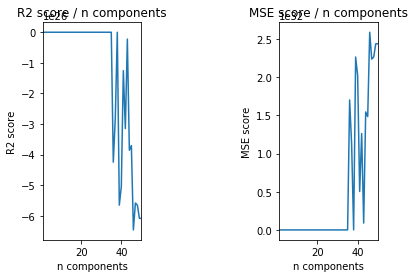

In [21]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [22]:
r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])



Best n: 38 R2 score: 0.15434386983037152
Best n: 38 MSE: 338684.2759162816


## IV. Conclusion:

The result are pretty similar and seems to not have a huge rental difference by area. The machine learning models can't be used to predict precisely the difference of rental value.

Based on the observed coefficient correlations, fancy places like Art Gallery seem to boost rental value the most and the lower values are in immigration and minority groups Cities as we can see by the venues, you can see over the data that more internacional resturants such "Burrito Place" or "Filipino Restaurant" 
